
## MultiModal Prompting With YOLOv10

**NOTE:** Currently, YOLOv10 does not have its own PyPI package. Therefore, we need to install the code from the source.

In [4]:
!pip install -q git+https://github.com/THU-MIG/yolov10.git
!pip install -q supervision roboflow
import os
HOME = os.getcwd()
print(HOME)

!mkdir -p {HOME}/weights
!wget -P {HOME}/weights -q https://github.com/THU-MIG/yolov10/releases/download/v1.1/yolov10l.pt
!ls -lh {HOME}/weights

!mkdir -p {HOME}/data
!wget -P {HOME}/data -q https://cf.dtcj.com/0559d3e0-e239-4a40-98d6-e0b5c01d37a0.jpg  -O test.jpg
!ls -lh {HOME}/data

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
/content
total 100M
-rw-r--r-- 1 root root 100M May 26 15:53 yolov10l.pt
total 0


In [31]:
import cv2
import numpy as np
import supervision as sv
from ultralytics import YOLOv10

def sort_detections(detections):
    # 按从左到右、从上到下的顺序对检测结果进行排序
    indices = np.lexsort((detections.xyxy[:, 1], detections.xyxy[:, 0]))
    sorted_detections = sv.Detections(
        xyxy=detections.xyxy[indices],
        mask=detections.mask if detections.mask is not None else None,
        confidence=detections.confidence[indices],
        class_id=detections.class_id[indices],
        tracker_id=detections.tracker_id if detections.tracker_id is not None else None,
        data={'class_name': detections.data['class_name'][indices]}
    )
    return sorted_detections


def generate_detections_table(detections):
    # 收集各个物体的标签，框信息，置信度
    detection_info = []

    for idx, (bbox, confidence, class_id) in enumerate(zip(detections.xyxy, detections.confidence, detections.class_id)):
        class_name = detections.data['class_name'][idx]
        detection_info.append({
            "ID": idx + 1,
            "Class Name": class_name,
            "Bounding Box": f"({bbox[0]:.2f}, {bbox[1]:.2f}, {bbox[2]:.2f}, {bbox[3]:.2f})",
            "Confidence": confidence
        })

    # 生成 Markdown 表格
    table_header = "| ID | Class Name | Bounding Box | Confidence |\n|----|-------------|---------------|------------|\n"
    table_rows = ""

    for info in detection_info:
        row = f"| {info['ID']} | {info['Class Name']} | {info['Bounding Box']} | {info['Confidence']:.2f} |\n"
        table_rows += row

    markdown_table = table_header + table_rows
    return markdown_table

def generate_results(image_path):
    # 加载模型
    model = YOLOv10(f'{HOME}/weights/yolov10l.pt')

    # 读取图像
    image = cv2.imread(image_path)

    # 获取检测结果
    results = model(image)[0]
    detections = sv.Detections.from_ultralytics(results)

    # 应用非极大值抑制
    nms_detections = detections.with_nms(threshold=0.5)

    # 对检测结果排序
    sorted_detections = sort_detections(nms_detections)

    # 初始化标注器
    bounding_box_annotator = sv.BoundingBoxAnnotator()
    label_annotator = sv.LabelAnnotator(text_scale=0.3, text_thickness=1, text_padding=5)  # 调整字体大小和厚度

    # 标注图像
    annotated_image = bounding_box_annotator.annotate(scene=image, detections=sorted_detections)

    # 为每个检测框添加编号标签
    labels = [f"{idx+1}-{sorted_detections.data['class_name'][idx]}" for idx in range(len(sorted_detections))]
    annotated_image = label_annotator.annotate(scene=annotated_image, detections=sorted_detections, labels=labels)

    # 显示标注后的图像
    sv.plot_image(annotated_image)

    # 生成并打印 Markdown 表格
    markdown_table = generate_detections_table(sorted_detections)
    print(markdown_table)



0: 384x640 6 persons, 4 chairs, 36.7ms
Speed: 1.6ms preprocess, 36.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


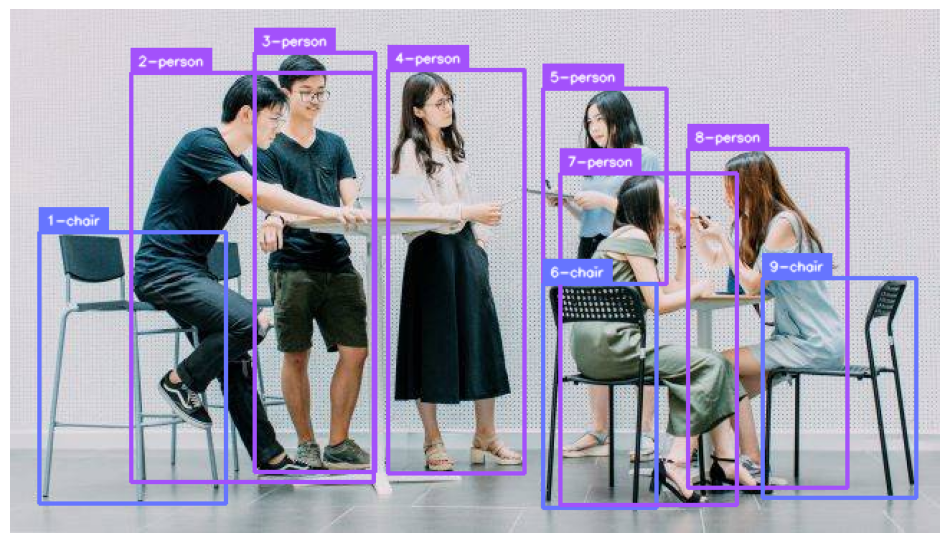

| ID | Class Name | Bounding Box | Confidence |
|----|-------------|---------------|------------|
| 1 | chair | (20.34, 155.42, 150.07, 344.22) | 0.62 |
| 2 | person | (84.96, 44.72, 253.32, 329.43) | 0.91 |
| 3 | person | (170.28, 30.43, 254.80, 322.51) | 0.90 |
| 4 | person | (263.57, 42.82, 358.20, 323.83) | 0.92 |
| 5 | person | (371.54, 55.56, 457.45, 191.24) | 0.76 |
| 6 | chair | (371.73, 191.54, 450.67, 347.41) | 0.62 |
| 7 | person | (383.31, 114.86, 506.21, 345.17) | 0.83 |
| 8 | person | (472.46, 97.49, 583.54, 333.69) | 0.89 |
| 9 | chair | (524.88, 187.41, 631.49, 340.05) | 0.91 |



In [36]:
image_path = "test.jpg"
generate_results(image_path)